# Module 1: 基础设置与依赖库 (Setup)


In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 绘图风格设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


# Module 2: 数据载入 (Data Loading)

🚀 Loading data from data/EOG_data...
✅ Loaded 73 files.


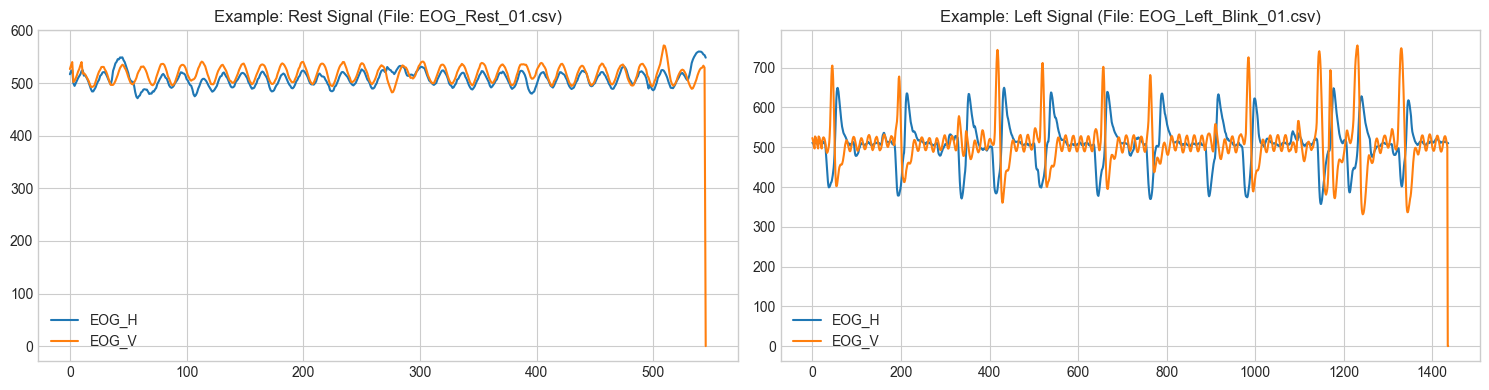

In [3]:
# Cell 2: Data Loading Function

# ==== 配置区域 ====
DATA_PATH = "data/EOG_data"  # 你的数据路径
CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"]
SAMPLING_RATE = 50  # 假设采样率 50Hz (delay 20ms)

def load_raw_data():
    raw_data = [] # 存放波形 (N, 2)
    labels = []   # 存放标签 ID
    filenames = [] # 存放文件名方便debug

    print(f"🚀 Loading data from {DATA_PATH}...")
    
    for label_name in CLASSES:
        folder_path = os.path.join(DATA_PATH, label_name)
        if not os.path.exists(folder_path):
            continue
            
        csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
        
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            try:
                # 读取指定的列 (根据你之前的截图)
                df = pd.read_csv(file_path, header=0, usecols=['data 0', 'data 1'])
                df.columns = ['EOG_H', 'EOG_V'] # 重命名
                
                # 转为数值并去空
                df = df.apply(pd.to_numeric, errors='coerce').dropna()
                
                # 简单清洗：丢弃太短的文件 (<1秒)
                if len(df) < SAMPLING_RATE:
                    continue
                    
                raw_data.append(df.values)
                labels.append(CLASSES.index(label_name))
                filenames.append(file)
                
            except Exception as e:
                print(f"❌ Error reading {file}: {e}")

    print(f"✅ Loaded {len(raw_data)} files.")
    return raw_data, np.array(labels), filenames

# 执行加载
X_raw_list, y_raw_list, filenames = load_raw_data()

# 画个图检查一下 Rest 和 Action 的区别
plt.figure(figsize=(15, 4))

# 1. 画 Rest 信号
# np.where 返回满足条件的索引列表
rest_indices = np.where(y_raw_list == 0)[0] 

if len(rest_indices) > 0:
    idx_rest = rest_indices[0] # 取第一个 Rest 样本的索引
    plt.subplot(1, 2, 1)
    plt.plot(X_raw_list[idx_rest]) # 使用整数索引去访问列表
    plt.title(f"Example: Rest Signal (File: {filenames[idx_rest]})")
    plt.legend(['EOG_H', 'EOG_V'])
else:
    print("⚠️ Warning: No 'Rest' data found to plot.")

# 2. 画 Left 信号 (假设 Left 是第 3 类，根据你的CLASSES顺序)
# CLASSES = ["Rest", "Up", "Down", "Left", "Right", "Blink"] -> Left is index 3
left_indices = np.where(y_raw_list == 3)[0]

if len(left_indices) > 0:
    idx_left = left_indices[0] # 取第一个 Left 样本的索引
    plt.subplot(1, 2, 2)
    plt.plot(X_raw_list[idx_left])
    plt.title(f"Example: Left Signal (File: {filenames[idx_left]})")
    plt.legend(['EOG_H', 'EOG_V'])
else:
    print("⚠️ Warning: No 'Left' data found to plot.")

plt.tight_layout()
plt.show()

# Module 3: 数据预处理 (Preprocessing & Filtering)

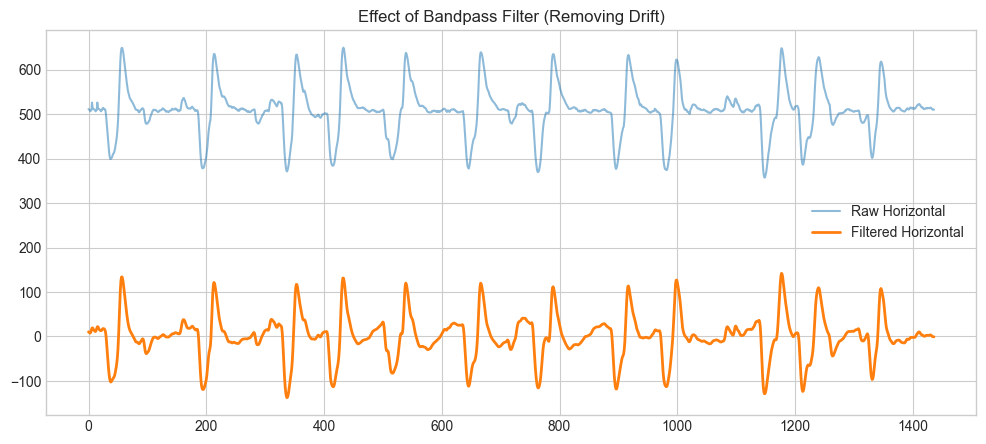

In [4]:
# Cell 3: Preprocessing (Bandpass Filter)

def apply_filter(data, lowcut=0.5, highcut=10.0, fs=50, order=4):
    """
    带通滤波器：
    - 去除 < 0.5Hz 的基线漂移 (非常重要！)
    - 去除 > 10Hz 的高频肌电噪音
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data, axis=0)

X_filtered_list = [apply_filter(d) for d in X_raw_list]

# 可视化滤波效果 (对比)
idx = np.where(y_raw_list == 3)[0][0] # 找一个 Left 的样本
plt.figure(figsize=(12, 5))
plt.plot(X_raw_list[idx][:, 0], label='Raw Horizontal', alpha=0.5)
plt.plot(X_filtered_list[idx][:, 0], label='Filtered Horizontal', linewidth=2)
plt.title("Effect of Bandpass Filter (Removing Drift)")
plt.legend()
plt.show()

# Module 4: 特征工程 (Advanced Feature Extraction)

In [11]:
# Cell 4: Windowing & Feature Extraction

WINDOW_SIZE = 50  # 1秒窗口
STEP_SIZE = 10    # 滑动步长

# 修改 Module 4 中的 extract_features 函数

def extract_features(data_list, label_list):
    X_feat = []
    y_feat = []
    
    # 设定一个清洗阈值
    # 你可以根据刚才的图来看，真正的波峰都在 100 以上，噪音都在 50 以下
    # 所以设定 50-80 是比较合理的
    CLEANING_THRESHOLD = 60.0 
    
    for i, data in enumerate(data_list):
        original_label = label_list[i]
        
        # 滑动窗口
        for start in range(0, len(data) - WINDOW_SIZE, STEP_SIZE):
            window = data[start:start+WINDOW_SIZE]
            
            # --- 1. 计算峰峰值 (P2P) ---
            # 我们主要看水平(H)和垂直(V)两个通道谁的动静大
            ptp_h = np.max(window[:, 0]) - np.min(window[:, 0])
            ptp_v = np.max(window[:, 1]) - np.min(window[:, 1])
            max_ptp = max(ptp_h, ptp_v)
            
            # --- 2. 标签清洗核心逻辑 (The Fix) ---
            # 如果波形太平，即使它来自 'Left' 文件夹，我们也把它标记为 'Rest' (0)
            # 假设 Rest 的 label ID 是 0
            if max_ptp < CLEANING_THRESHOLD:
                current_label = 0 # 强制改为 Rest
            else:
                current_label = original_label # 保留原始标签

            # --- 3. 提取特征 (保持不变) ---
            row_features = []
            for axis in range(2): 
                sig = window[:, axis]
                row_features.append(np.std(sig))    
                row_features.append(np.max(sig) - np.min(sig)) 
                diff = np.diff(sig)
                row_features.append(np.mean(np.abs(diff))) 
                row_features.append(np.max(np.abs(diff)))
                row_features.append(skew(sig)) 
                row_features.append(kurtosis(sig))
                row_features.append(np.sum(sig**2))

            X_feat.append(row_features)
            y_feat.append(current_label) # 注意这里 append 的是清洗后的标签
            
    return np.array(X_feat), np.array(y_feat)
print("Extracting features...")
X, y = extract_features(X_filtered_list, y_raw_list)
print(f"Feature Matrix Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Extracting features...
Feature Matrix Shape: (14998, 14)
Labels Shape: (14998,)


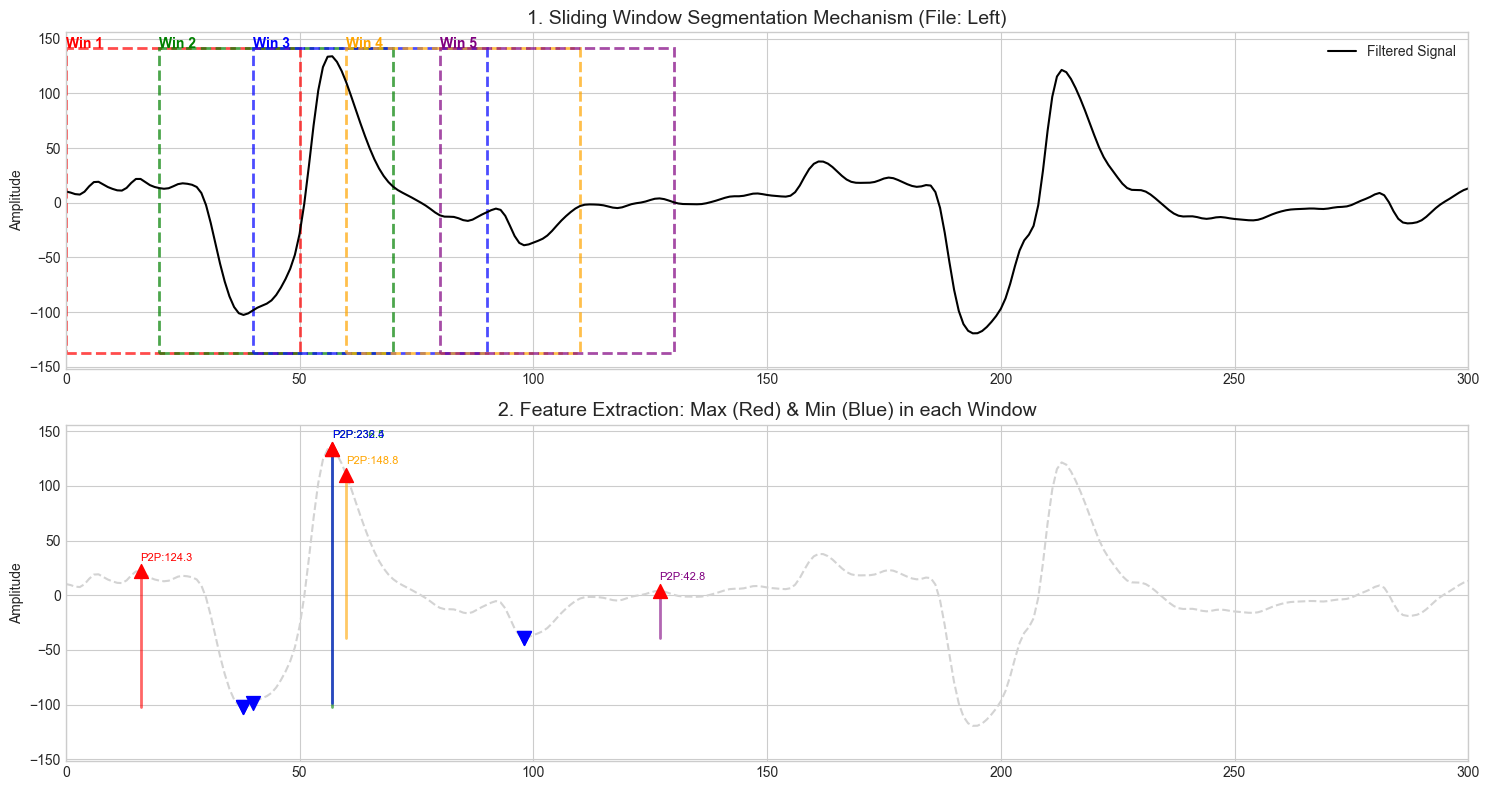

In [18]:
import matplotlib.patches as patches

# ==== 1. 随便选一个动作文件来演示 ====
# 假设我们选 'Left' 文件夹里的第一个文件
target_label = "Left"
file_idx = 0 
target_file = os.path.join(DATA_PATH, target_label, 
                           os.listdir(os.path.join(DATA_PATH, target_label))[file_idx])

# 读取并滤波 (使用之前的 apply_filter 函数)
df = pd.read_csv(target_file, header=0, usecols=['data 0', 'data 1'])
df.columns = ['EOG_H', 'EOG_V']
raw_signal = df['EOG_H'].values # 我们只看水平信号演示
filtered_signal = apply_filter(raw_signal.reshape(-1, 1)).flatten()

# ==== 2. 可视化设置 ====
WINDOW_SIZE = 50
STEP_SIZE = 20 # 步长设大一点方便看清楚

plt.figure(figsize=(15, 8))

# --- 子图 1: 展示滑动窗口是如何“暴力切分”的 ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(filtered_signal, color='black', linewidth=1.5, label='Filtered Signal')
ax1.set_title(f"1. Sliding Window Segmentation Mechanism (File: {target_label})", fontsize=14)

# 画出前 5 个窗口
colors = ['red', 'green', 'blue', 'orange', 'purple']
for i in range(5):
    start = i * STEP_SIZE
    end = start + WINDOW_SIZE
    
    # 在图上画框
    rect = patches.Rectangle((start, min(filtered_signal)), WINDOW_SIZE, max(filtered_signal)-min(filtered_signal), 
                             linewidth=2, edgecolor=colors[i], facecolor='none', alpha=0.7, linestyle='--')
    ax1.add_patch(rect)
    ax1.text(start, max(filtered_signal), f"Win {i+1}", color=colors[i], fontweight='bold')

ax1.set_xlim(0, 300) # 只看前300个点
ax1.set_ylabel("Amplitude")
ax1.legend(loc='upper right')

# --- 子图 2: 展示峰值特征提取 (Peak-to-Peak) ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(filtered_signal, color='lightgray', linestyle='--')
ax2.set_title("2. Feature Extraction: Max (Red) & Min (Blue) in each Window", fontsize=14)

# 对刚才那 5 个窗口提取特征并画点
for i in range(5):
    start = i * STEP_SIZE
    end = start + WINDOW_SIZE
    window_data = filtered_signal[start:end]
    
    # 找到窗口内的最大值和最小值的索引
    # 注意：argmax 返回的是相对窗口的索引，需要加上 start 才是全局索引
    max_idx = np.argmax(window_data) + start
    min_idx = np.argmin(window_data) + start
    
    # 画出特征点
    ax2.scatter(max_idx, filtered_signal[max_idx], color='red', s=100, zorder=5, marker='^') # Max
    ax2.scatter(min_idx, filtered_signal[min_idx], color='blue', s=100, zorder=5, marker='v') # Min
    
    # 画连接线表示 "Peak-to-Peak Amplitude"
    ax2.plot([max_idx, max_idx], [filtered_signal[min_idx], filtered_signal[max_idx]], 
             color=colors[i], linestyle='-', linewidth=2, alpha=0.6)
    
    # 标注数值
    ptp_value = filtered_signal[max_idx] - filtered_signal[min_idx]
    ax2.text(max_idx, filtered_signal[max_idx]+10, f"P2P:{ptp_value:.1f}", fontsize=8, color=colors[i])

ax2.set_xlim(0, 300)
ax2.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Module 5: 模型训练与对比 (Model Comparison)

Training Random Forest...
--> Random Forest Accuracy: 0.8857
Training SVM (RBF)...
--> SVM (RBF) Accuracy: 0.8240
Training KNN (k=5)...
--> KNN (k=5) Accuracy: 0.8270


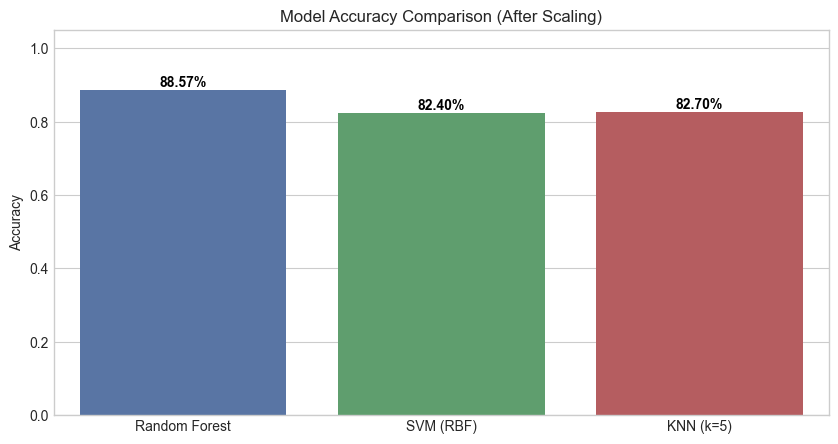

In [12]:
# Cell 5: Model Training & Comparison (Fixed)

from sklearn.preprocessing import StandardScaler

# 1. 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. [关键步骤] 特征归一化 (Standardization)
# 这一步对于 SVM 和 KNN 至关重要！
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # 注意：测试集只能 transform，不能 fit

# 3. 定义模型
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # 树模型(RF)其实不需要缩放，但缩放了也没坏处
    # SVM 和 KNN 必须用缩放后的数据 (X_train_scaled)
    if name == "Random Forest":
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"--> {name} Accuracy: {acc:.4f}")

# 4. 画图 (修复坐标轴)
plt.figure(figsize=(10, 5))
# 使用不同的颜色
colors = ['#4c72b0', '#55a868', '#c44e52']
barplot = sns.barplot(x=list(results.keys()), y=list(results.values()), palette=colors)

# 在柱子上方显示具体数值
for i, v in enumerate(results.values()):
    barplot.text(i, v + 0.01, f'{v:.2%}', ha='center', color='black', fontweight='bold')

plt.ylim(0.0, 1.05) # 设置 Y 轴为 0 到 1.05，确保所有柱子都能看见
plt.title("Model Accuracy Comparison (After Scaling)")
plt.ylabel("Accuracy")
plt.show()

# Module 6: 深度评估与误触分析 (Evaluation)

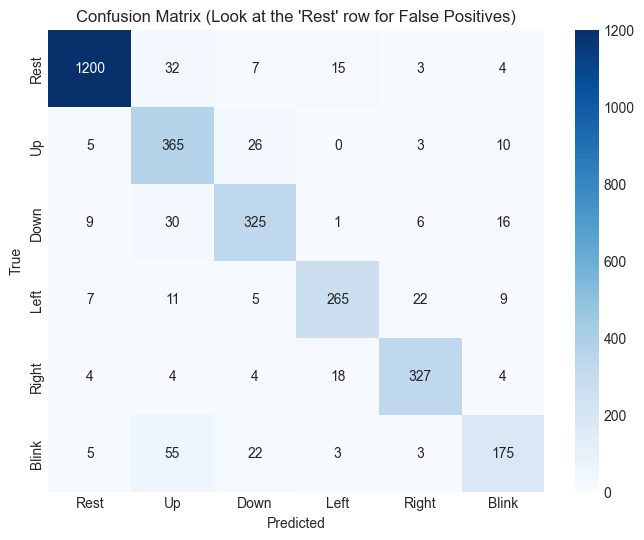

              precision    recall  f1-score   support

        Rest       0.98      0.95      0.96      1261
          Up       0.73      0.89      0.81       409
        Down       0.84      0.84      0.84       387
        Left       0.88      0.83      0.85       319
       Right       0.90      0.91      0.90       361
       Blink       0.80      0.67      0.73       263

    accuracy                           0.89      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.89      0.89      0.89      3000

Total False Positives (Rest predicted as Action): 61
Visualizing some False Positive examples...


In [17]:
# Cell 6: Detailed Evaluation (Focus on False Positives)

# 选出表现最好的模型 (通常是 Random Forest)
best_model = models["Random Forest"]
y_pred = best_model.predict(X_test)

# 1. 混淆矩阵
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix (Look at the 'Rest' row for False Positives)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. 打印分类报告
print(classification_report(y_test, y_pred, target_names=CLASSES))

# 3. 误触分析：找出那些本来是 Rest 但被预测成动作的样本
false_positives = np.where((y_test == 0) & (y_pred != 0))[0] # 0 is Rest

print(f"Total False Positives (Rest predicted as Action): {len(false_positives)}")

if len(false_positives) > 0:
    print("Visualizing some False Positive examples...")
    # 随机看几个误触的样本特征（虽然这里看不到原始波形，但能看到特征分布）
    # 如果你想看原始波形，需要在切片时保留索引，这比较复杂，现阶段先看数量。
else:
    print("Excellent! No False Positives in the test set.")

# Module 7: 保存最佳模型

In [16]:
# Cell 7: Save Model
import joblib
joblib.dump(best_model, 'eog_model_v2.joblib')
joblib.dump(scaler, 'eog_scaler.joblib')
print("Model and scaler saved as eog_model_v2.joblib, and eog_scaler.joblib")

Model and scaler saved as eog_model_v2.joblib, and eog_scaler.joblib
